# ProgLearn on spoken_digit


In [1]:
import os #read path

import numpy as np

import matplotlib.pyplot as plt 

import librosa #process audio
import librosa.display

import cv2

In [2]:
#proglearn
import pandas as pd
from sklearn.model_selection import train_test_split
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
import time

In [3]:
#cross-validation
from sklearn.model_selection import StratifiedKFold

In [4]:
file = os.listdir('D:/Python Exploration/free-spoken-digit-dataset/recordings')
AudioData=[] #audio data
X_spec = [] #STFT spectrum by librosa
X_spec_mini = [] #resize to 28*28
Y_number = [] #label of number
Y_speaker = [] #label of speaker

Label_speaker = ['g', 'j', 'l', 'n', 't', 'y'] #first letter of speaker's name

for i in file:
    x , sr = librosa.load('D:/Python Exploration/free-spoken-digit-dataset/recordings/'+i, sr = 8000) # path of the audio files
    X = librosa.stft(x,n_fft = 128) #short time fourier transform
    Xdb = librosa.amplitude_to_db(abs(X)) #Convert an amplitude spectrogram to dB-scaled spectrogram
    Xdb_28 = cv2.resize(Xdb, (28, 28))
    y_n = i[0] #number
    y_s = i[2] #first letter of speaker
    
    AudioData.append(x)
    X_spec.append(Xdb)
    X_spec_mini.append(Xdb_28)
    Y_number.append(y_n)
    Y_speaker.append(y_s)


In [23]:
# play the audio (NO.3000 audio, number 9)
import IPython.display as ipd

num = 2222
print('This is a number',Y_number[num],'spoken by speaker',Y_speaker[num],'\nLength:',AudioData[num].shape[0],'points')
ipd.Audio(AudioData[num], rate=sr)

This is a number 7 spoken by speaker l 
Length: 10399 points


Text(0.5, 1.0, 'Transformed into 28x28 size')

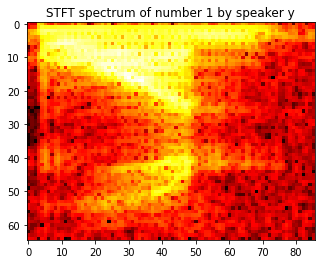

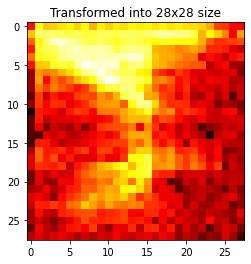

In [25]:
# check the effects of .resize()
num = 555 #choose from 0 to 2999

fig1,ax1 = plt.subplots()
plt.imshow(X_spec[num], cmap='hot', interpolation='nearest')
plt.title('STFT spectrum of number '+Y_number[num]+' by speaker '+Y_speaker[num])

fig2,ax2 = plt.subplots()
plt.imshow(X_spec_mini[num], cmap='hot', interpolation= 'nearest')
plt.title('Transformed into 28x28 size')

# use the 28x28 for further analysis

In [28]:
# Description
n_audio = 3000
n_speaker = 6
n_per_class = 10
n_per_class_per_speaker = 50

# Flattening
X_all = np.array(X_spec_mini).reshape(n_audio,-1) #(3000, 784)
Y_all = np.array(Y_number).astype(int)#.reshape(n_audio,-1) #(3000, 1) ## it seems that the shape should be (3000,) rather than (3000,1)
Y_all_speaker = np.array(Y_speaker) #(3000,)string

In [35]:
Y_all_speaker

array(['g', 'g', 'g', ..., 'y', 'y', 'y'], dtype='<U1')

g
[2737 2701 2747 2738 2720 2727 2732 2731]
j
[2754 2789 2771 2770 2778 2797 2765 2795]
l
[2847 2819 2823 2810 2836 2849 2841 2840]
n
[2881 2850 2878 2854 2876 2855 2893 2864]
t
[2936 2925 2903 2941 2942 2939 2915 2916]
y
[2972 2987 2985 2999 2981 2990 2997 2977]


Text(0.5, 0.98, 'Short-Time Fourier Transform Spectrogram of Number 9 by Six Speakers')

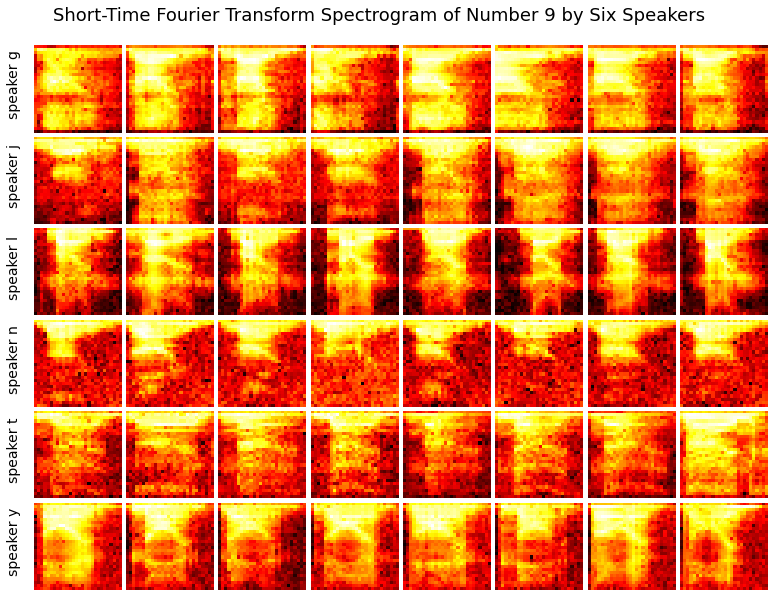

In [27]:
#
number = 9 #choose a number
fig, axes = plt.subplots(nrows=6, ncols=8, sharex=True, sharey=True, figsize=(12, 9))

for j,speaker in enumerate(Label_speaker):
    opt = np.where((Y_all_speaker == speaker)&(Y_all == number))[0]
    ch = np.random.choice(opt,8,replace=False) #randomly choose 8 different samples for plotting
    print(speaker)
    print(ch)
    for i in range(8):
        axes[j,i].imshow(X_spec_mini[ch[i]], cmap='hot', interpolation='nearest')
        axes[j,i].axis('off')
        if i == 0: axes[j,i].text(-9, 12, 'speaker '+speaker, size=14, va='center', rotation='vertical')
        else: continue
                
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.05,
                    wspace=0.05)
plt.suptitle("Short-Time Fourier Transform Spectrogram of Number "+str(number)+" by Six Speakers", fontsize=18)

### Cross-validation
The dataset is small. So I use cross-validation and average the result, in order to make it more reliable. Also, I should run it for enough iterations.

In [92]:
df = pd.DataFrame()

acc = []
num_trees = []
time_train = []
time_inf = []

########################################################### initialize proglearn
default_transformer_class = TreeClassificationTransformer
default_transformer_kwargs = {"kwargs": {"max_depth": 30}}
default_voter_class = TreeClassificationVoter
default_voter_kwargs = {}
default_decider_class = SimpleArgmaxAverage

###########################################################
for i in range(2):
    for n_tree in range(10,31):
        accuracies = []
        train_times_across_tasks = []
        inference_times_across_tasks = []

        skf = StratifiedKFold(n_splits = 10)
        for train_idx, test_idx in skf.split(X_all, Y_all):

            X_train , X_test = X_all[train_idx] , X_all[test_idx]
            Y_train , Y_test = Y_all[train_idx] , Y_all[test_idx]

            progressive_learner = ProgressiveLearner(
                default_transformer_class=default_transformer_class,
                default_transformer_kwargs=default_transformer_kwargs,
                default_voter_class=default_voter_class,
                default_voter_kwargs=default_voter_kwargs,
                default_decider_class=default_decider_class,
            )
            train_start_time = time.time()
            progressive_learner.add_task(
                X=X_train,
                y=Y_train,
                task_id=0,
                num_transformers=n_tree,
                transformer_voter_decider_split=[0.67, 0.33, 0],
                decider_kwargs={"classes": np.unique(Y_train)},
            )

            train_end_time = time.time()

            inference_start_time = time.time()
            task_0_predictions = progressive_learner.predict(X_test, task_id=0)
            inference_end_time = time.time()
            accuracies.append(np.mean(task_0_predictions == Y_test))
            train_times_across_tasks.append(train_end_time - train_start_time)
            inference_times_across_tasks.append(inference_end_time - inference_start_time)
            print('iter: ',i,'\nn_tree: ',n_tree,', cross-validation.','Current accuracies:',accuracies)
        num_trees.append(n_tree)
        acc.append(np.mean(accuracies))
        time_train.append(np.mean(train_times_across_tasks))
        time_inf.append(np.mean(inference_times_across_tasks))
        print('When n_tree is ',n_tree,', the accuracy is ',np.mean(accuracies))

iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667, 0.7633333333333333]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667, 0.7633333333333333, 0.7233333333333334]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667, 0.7633333333333333, 0.7233333333333334, 0.6266666666666667]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667, 0.7633333333333333, 0.7233333333333334, 0.6266666666666667, 0.7533333333333333]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667, 0.7633333333333333, 0.7233333333333334, 0.6266666666666667, 0.7533333333333333, 0.83]
iter:  0 
n_tree:  10 , cross-validation. Current accuracies: [0.72, 0.8566666666666667, 0.7633333333333333, 0.

iter:  0 
n_tree:  15 , cross-validation. Current accuracies: [0.7533333333333333, 0.89, 0.8233333333333334, 0.7633333333333333, 0.62, 0.72, 0.7866666666666666, 0.7566666666666667]
iter:  0 
n_tree:  15 , cross-validation. Current accuracies: [0.7533333333333333, 0.89, 0.8233333333333334, 0.7633333333333333, 0.62, 0.72, 0.7866666666666666, 0.7566666666666667, 0.84]
iter:  0 
n_tree:  15 , cross-validation. Current accuracies: [0.7533333333333333, 0.89, 0.8233333333333334, 0.7633333333333333, 0.62, 0.72, 0.7866666666666666, 0.7566666666666667, 0.84, 0.72]
When n_tree is  15 , the accuracy is  0.7673333333333333
iter:  0 
n_tree:  16 , cross-validation. Current accuracies: [0.7133333333333334]
iter:  0 
n_tree:  16 , cross-validation. Current accuracies: [0.7133333333333334, 0.8366666666666667]
iter:  0 
n_tree:  16 , cross-validation. Current accuracies: [0.7133333333333334, 0.8366666666666667, 0.82]
iter:  0 
n_tree:  16 , cross-validation. Current accuracies: [0.7133333333333334, 0.83

iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666]
iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8533333333333334]
iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8533333333333334, 0.8733333333333333]
iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8533333333333334, 0.8733333333333333, 0.8166666666666667]
iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8533333333333334, 0.8733333333333333, 0.8166666666666667, 0.6033333333333334]
iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8533333333333334, 0.8733333333333333, 0.8166666666666667, 0.6033333333333334, 0.76]
iter:  0 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8533333333333334, 0.8733333333333333, 0.8166666666666667, 0.6033333333333334, 0.76, 0.8166666666666667]
iter:  0 
n_tree:  21 , cro

iter:  0 
n_tree:  26 , cross-validation. Current accuracies: [0.74, 0.89, 0.8066666666666666, 0.7933333333333333, 0.6733333333333333, 0.7966666666666666, 0.8133333333333334]
iter:  0 
n_tree:  26 , cross-validation. Current accuracies: [0.74, 0.89, 0.8066666666666666, 0.7933333333333333, 0.6733333333333333, 0.7966666666666666, 0.8133333333333334, 0.78]
iter:  0 
n_tree:  26 , cross-validation. Current accuracies: [0.74, 0.89, 0.8066666666666666, 0.7933333333333333, 0.6733333333333333, 0.7966666666666666, 0.8133333333333334, 0.78, 0.88]
iter:  0 
n_tree:  26 , cross-validation. Current accuracies: [0.74, 0.89, 0.8066666666666666, 0.7933333333333333, 0.6733333333333333, 0.7966666666666666, 0.8133333333333334, 0.78, 0.88, 0.77]
When n_tree is  26 , the accuracy is  0.7943333333333333
iter:  0 
n_tree:  27 , cross-validation. Current accuracies: [0.8166666666666667]
iter:  0 
n_tree:  27 , cross-validation. Current accuracies: [0.8166666666666667, 0.8433333333333334]
iter:  0 
n_tree:  27

iter:  1 
n_tree:  10 , cross-validation. Current accuracies: [0.75, 0.84, 0.7666666666666667, 0.7233333333333334, 0.6466666666666666, 0.76, 0.79, 0.6766666666666666, 0.7933333333333333]
iter:  1 
n_tree:  10 , cross-validation. Current accuracies: [0.75, 0.84, 0.7666666666666667, 0.7233333333333334, 0.6466666666666666, 0.76, 0.79, 0.6766666666666666, 0.7933333333333333, 0.6633333333333333]
When n_tree is  10 , the accuracy is  0.7409999999999999
iter:  1 
n_tree:  11 , cross-validation. Current accuracies: [0.7766666666666666]
iter:  1 
n_tree:  11 , cross-validation. Current accuracies: [0.7766666666666666, 0.8233333333333334]
iter:  1 
n_tree:  11 , cross-validation. Current accuracies: [0.7766666666666666, 0.8233333333333334, 0.7933333333333333]
iter:  1 
n_tree:  11 , cross-validation. Current accuracies: [0.7766666666666666, 0.8233333333333334, 0.7933333333333333, 0.7566666666666667]
iter:  1 
n_tree:  11 , cross-validation. Current accuracies: [0.7766666666666666, 0.823333333333

iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334]
iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334, 0.8466666666666667]
iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334, 0.8466666666666667, 0.8033333333333333]
iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334, 0.8466666666666667, 0.8033333333333333, 0.7333333333333333]
iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334, 0.8466666666666667, 0.8033333333333333, 0.7333333333333333, 0.67]
iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334, 0.8466666666666667, 0.8033333333333333, 0.7333333333333333, 0.67, 0.7733333333333333]
iter:  1 
n_tree:  16 , cross-validation. Current accuracies: [0.7033333333333334, 0.8466666666666667, 0.8033333333333333, 0.7333333333333333, 0.67, 0.7733333333333333, 0.83]
iter:  1 
n_tree:  16 , cross-validation. Current accur

iter:  1 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8633333333333333, 0.88, 0.79, 0.6433333333333333, 0.7566666666666667, 0.8366666666666667, 0.8133333333333334]
iter:  1 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8633333333333333, 0.88, 0.79, 0.6433333333333333, 0.7566666666666667, 0.8366666666666667, 0.8133333333333334, 0.8533333333333334]
iter:  1 
n_tree:  21 , cross-validation. Current accuracies: [0.7866666666666666, 0.8633333333333333, 0.88, 0.79, 0.6433333333333333, 0.7566666666666667, 0.8366666666666667, 0.8133333333333334, 0.8533333333333334, 0.7233333333333334]
When n_tree is  21 , the accuracy is  0.7946666666666666
iter:  1 
n_tree:  22 , cross-validation. Current accuracies: [0.7533333333333333]
iter:  1 
n_tree:  22 , cross-validation. Current accuracies: [0.7533333333333333, 0.8533333333333334]
iter:  1 
n_tree:  22 , cross-validation. Current accuracies: [0.7533333333333333, 0.8533333333333334, 0.86]
ite

iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666]
iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666, 0.8833333333333333]
iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666, 0.8833333333333333, 0.8866666666666667]
iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666, 0.8833333333333333, 0.8866666666666667, 0.8233333333333334]
iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666, 0.8833333333333333, 0.8866666666666667, 0.8233333333333334, 0.61]
iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666, 0.8833333333333333, 0.8866666666666667, 0.8233333333333334, 0.61, 0.8166666666666667]
iter:  1 
n_tree:  27 , cross-validation. Current accuracies: [0.7766666666666666, 0.8833333333333333, 0.8866666666666667, 0.8233333333333334, 0.61, 0.8166666666666667, 0.8533333333333334]
iter:  1 
n_tree:  27 , cross-validation.

([<matplotlib.axis.XTick at 0x16d1c9de850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

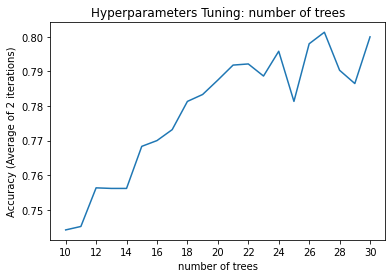

In [116]:
# Accuracy-ntree plot

t = np.array(num_trees).reshape((2,-1))
t = np.average(t,axis =0)
a = np.array(acc).reshape((2,-1))
a = np.average(a,axis =0)

plt.figure()
plt.subplot()
plt.plot(t,a)
plt.xlabel('number of trees')
plt.ylabel('Accuracy (Average of 2 iterations)')
plt.title('Hyperparameters Tuning: number of trees')
plt.xticks(range(10,31,2))

In [179]:
# sklearn Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

acc_RandomForest = []
for i in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.25)
    clf = RandomForestClassifier(n_estimators=19, max_depth=30)
    clf = clf.fit(X_train, y_train)
    Y_predict = clf.predict(X_test)
    accuracy=accuracy_score(Y_predict,y_test)
    #print('Accuracy_RandomForest: ',accuracy)
    acc_RandomForest.append(accuracy)

In [180]:
np.mean(acc_RandomForest)

0.9028533333333334

In [148]:
acc_proglean = []
for i in range(50):
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.25)
    progressive_learner = ProgressiveLearner(
        default_transformer_class=default_transformer_class,
        default_transformer_kwargs=default_transformer_kwargs,
        default_voter_class=default_voter_class,
        default_voter_kwargs=default_voter_kwargs,
        default_decider_class=default_decider_class,
    )
    progressive_learner.add_task(
        X=X_train,
        y=Y_train,
        task_id=0,
        num_transformers=19,
        transformer_voter_decider_split=[0.67, 0.33, 0],
        decider_kwargs={"classes": np.unique(y_train)},
    )
    task_0_predictions = progressive_learner.predict(X_test, task_id=0)
    acc_proglean.append(np.mean(task_0_predictions == Y_test))
    #print(acc_proglean)


In [150]:
np.mean(acc_proglean)

0.84792

Text(0.5, 1.0, 'Comparison between L2F and RandomForest')

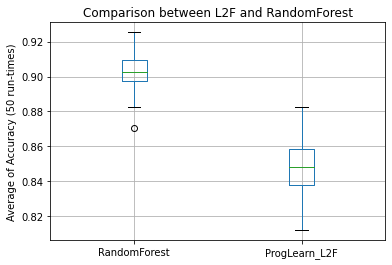

In [186]:
d = {'RandomForest': np.array(acc_RandomForest),
     'ProgLearn_L2F': np.array(acc_proglean)}
df = pd.DataFrame(data=d)
#boxplot = df.boxplot()
boxplot = df.boxplot(column=['RandomForest', 'ProgLearn_L2F'])
#plt.xlabel('Algorithm')
plt.ylabel('Average of Accuracy (50 run-times)')
plt.title('Comparison between L2F and RandomForest')


In [147]:
############################
num_iteration = 100
ntrees = 19


model = 'uf' # uf or dnn
speakers = Label_speaker.copy()
    
iteration = []
accuracies_across_tasks = []

############################

if model == "dnn":
    import keras
    from keras import layers
    default_transformer_class = NeuralClassificationTransformer

    network = keras.Sequential()
    network.add(
        layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=np.shape(train_x_task0)[1:],
        )
    )
    network.add(
        layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )
    network.add(
        layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )
    network.add(
        layers.Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )
    network.add(
        layers.Conv2D(
            filters=254,
            kernel_size=(3, 3),
            strides=2,
            padding="same",
            activation="relu",
        )
    )

    network.add(layers.Flatten())
    network.add(layers.Dense(2000, activation="relu"))
    network.add(layers.Dense(2000, activation="relu"))
    network.add(layers.Dense(units=10, activation="softmax"))

    default_transformer_kwargs = {
        "network": network,
        "euclidean_layer_idx": -2,
        "num_classes": 10,
        "optimizer": keras.optimizers.Adam(3e-4),
    }

    default_voter_class = KNNClassificationVoter
    default_voter_kwargs = {"k": int(np.log2(num_points_per_task * 0.33))}

    default_decider_class = SimpleArgmaxAverage
elif model == "uf":
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": 30}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    
    

######
for i in range(num_iteration):
    print('Iteration ',i)
    np.random.shuffle(speakers)
    for j , speaker in enumerate(speakers):
        index = np.where(Y_all_speaker==speaker)
        X = X_all[index]
        Y = Y_all[index]

        if j == 0:
            progressive_learner = ProgressiveLearner(
                default_transformer_class=default_transformer_class,
                default_transformer_kwargs=default_transformer_kwargs,
                default_voter_class=default_voter_class,
                default_voter_kwargs=default_voter_kwargs,
                default_decider_class=default_decider_class,
            )

            train_x_task0, test_x_task0, train_y_task0, test_y_task0 = train_test_split(X, Y, test_size=0.3)
            progressive_learner.add_task(
                X=train_x_task0,
                y=train_y_task0,
                task_id = 0,
                num_transformers= 1 if model == "dnn" else ntrees,
                transformer_voter_decider_split=[0.67, 0.33, 0],
                decider_kwargs={"classes": np.unique(train_y_task0)},
            )
            task_0_predictions = progressive_learner.predict(test_x_task0, task_id=0)
            iteration.append(i)
            accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))
            print('Task finished, accuracy: ',accuracies_across_tasks)
        else:
            progressive_learner.add_transformer(
                X=X,
                y=Y,
                transformer_data_proportion=1,
                num_transformers=1 if model == "dnn" else ntrees,
                backward_task_ids=[0],
            )
            task_0_predictions = progressive_learner.predict(test_x_task0, task_id=0)
            iteration.append(i)
            accuracies_across_tasks.append(np.mean(task_0_predictions == test_y_task0))
            print('Task finished, accuracy: ',accuracies_across_tasks)

print('All done!')

Iteration  0
Task finished, accuracy:  [0.88]
Task finished, accuracy:  [0.88, 0.88]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666]
Iteration  1
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.946

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.8

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94]
Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.973

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334]
Task

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

Task finished, accuracy:  [0.88, 0.88, 0.8866666666666667, 0.92, 0.92, 0.9266666666666666, 0.92, 0.9333333333333333, 0.9466666666666667, 0.96, 0.9733333333333334, 0.96, 0.9466666666666667, 0.9533333333333334, 0.9666666666666667, 0.98, 0.98, 0.9866666666666667, 0.8466666666666667, 0.86, 0.8533333333333334, 0.9, 0.9, 0.9, 0.9466666666666667, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.98, 0.8933333333333333, 0.9133333333333333, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333, 0.94, 0.94, 0.9533333333333334, 0.9733333333333334, 0.9733333333333334, 0.98, 0.98, 0.9333333333333333, 0.94, 0.96, 0.9666666666666667, 0.9733333333333334, 0.9733333333333334, 0.9466666666666667, 0.9733333333333334, 0.98, 0.98, 0.98, 0.9866666666666667, 0.8533333333333334, 0.84, 0.8466666666666667, 0.86, 0.8733333333333333, 0.8933333333333333, 0.94, 0.9466666666666667, 0.9533333333333334, 0.96, 0.96, 0.96, 0.9333333333333333, 0.9533333333333334, 0.96, 0.9666666666666667, 0.9533333333333334, 0.96

In [164]:
aver_accuracy = np.array(accuracies_across_tasks).reshape((num_iteration,6))
aver_accuracy = np.average(aver_accuracy,axis =0)

Text(0.5, 1.0, 'L2F: Average of Accuracy for 100 iterations')

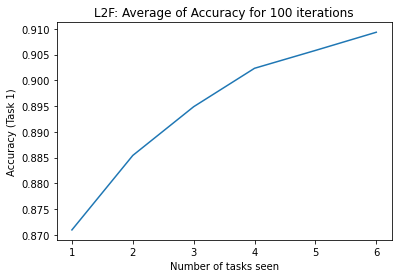

In [168]:
plt.figure()
plt.subplot()
plt.plot(range(1,7),aver_accuracy)
plt.xlabel('Number of tasks seen')
plt.ylabel('Accuracy (Task 1)')
plt.title('L2F: Average of Accuracy for 100 iterations')
#plt.xticks(range(10,31,2))

Text(0.5, 1.0, 'L2F: Backward Transfer Efficiency (100 iterations)')

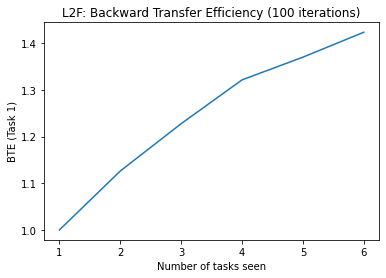

In [167]:
err = 1- aver_accuracy
bte = err[0]/err

plt.figure()
plt.subplot()
plt.plot(range(1,7),bte)
plt.xlabel('Number of tasks seen')
plt.ylabel('BTE (Task 1)')
plt.title('L2F: Backward Transfer Efficiency (100 iterations)')
